In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import mmap
import random
import pickle
import argparse
from tqdm.auto import tqdm

# Check if GPU is available, else use CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters
batch_size = 32        # Adjust according to your dataset and available memory
block_size = 128       # Size of the input sequence block
max_iters = 3000       # Maximum number of training iterations
learning_rate = 3e-4   # Learning rate for optimization
eval_iters = 50        # Evaluate the model every 'eval_iters' iterations
n_embd = 384           # Number of embeddings
n_head = 4             # Number of attention heads
n_layer = 4            # Number of layers in the transformer model
dropout = 0.2          # Dropout rate for regularization

# Display the chosen device
print(device)

cpu


In [2]:
# Read the text from the file
with open('wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Get the unique characters in the text
chars = sorted(set(text))
print(chars)

# Calculate the vocabulary size
vocab_size = len(chars)

['\n', ' ', '!', '"', '&', "'", '(', ')', '*', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\ufeff']


In [3]:
# Create mappings from characters to integers and vice versa
string_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_string = {i: ch for i, ch in enumerate(chars)}

# Function to encode a string into a list of integers
encode = lambda s: [string_to_int[c] for c in s]

# Function to decode a list of integers into a string
decode = lambda l: ''.join([int_to_string[i] for i in l])

In [4]:
# Convert the text into a tensor of integers
data = torch.tensor(encode(text), dtype=torch.long)

# Split the data into training and validation sets
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

# Function to get a batch of input-output pairs
def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    
    # Select input sequences (x) and corresponding target sequences (y)
    x = torch.stack([data_split[i:i + block_size] for i in ix])
    y = torch.stack([data_split[i + 1:i + block_size + 1] for i in ix])
    
    # Move the data to the chosen device (GPU or CPU)
    x, y = x.to(device), y.to(device)
    
    return x, y

In [5]:
# Decorator to disable gradient computation during estimation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()  # Set the model to evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)  # Forward pass to compute logits and loss
            losses[k] = loss.item()
        out[split] = losses.mean()  # Calculate the mean loss for the split
    model.train()  # Set the model back to training mode
    return out

In [6]:
class Head(nn.Module):
    """One head of self-attention"""

    def __init__(self, head_size):
        super().__init__()
        # Linear transformations for key, query, and value
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        # Triangular mask for masking future tokens in the sequence
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Input size: (batch, time-step, channels)
        # Output size: (batch, time-step, head size)
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        # Compute attention scores ("affinities")
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        # Perform the weighted aggregation of the values
        v = self.value(x)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out


class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Block(nn.Module):
    """Transformer block: communication followed by computation"""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


class GPTLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        # Token and position embeddings
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Stack of transformer blocks
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)
        # Linear layer for language modeling
        self.lm_head = nn.Linear(n_embd, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, index, targets=None):
        B, T = index.shape
        tok_emb = self.token_embedding_table(index)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            index_cond = index[:, -block_size:]
            logits, loss = self.forward(index_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            index_next = torch.multinomial(probs, num_samples=1)
            index = torch.cat((index, index_next), dim=1)
        return index


# Initialize the GPT language model
torch.manual_seed(42)
model = GPTLanguageModel(vocab_size)
m = model.to(device)


In [7]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
training_loss_lst = []
validation_loss_lst = []

for iter in tqdm(range(max_iters)):
    if iter % eval_iters == 0:
        losses = estimate_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")
        training_loss_lst.append(losses['train'])
        validation_loss_lst.append(losses['val'])

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/3000 [00:00<?, ?it/s]

step: 0, train loss: 4.480, val loss: 4.483
step: 50, train loss: 2.499, val loss: 2.550
step: 100, train loss: 2.426, val loss: 2.486
step: 150, train loss: 2.379, val loss: 2.442
step: 200, train loss: 2.288, val loss: 2.363
step: 250, train loss: 2.151, val loss: 2.244
step: 300, train loss: 2.036, val loss: 2.139
step: 350, train loss: 1.951, val loss: 2.050
step: 400, train loss: 1.860, val loss: 1.979
step: 450, train loss: 1.787, val loss: 1.924
step: 500, train loss: 1.729, val loss: 1.879
step: 550, train loss: 1.668, val loss: 1.829
step: 600, train loss: 1.629, val loss: 1.786
step: 650, train loss: 1.597, val loss: 1.755
step: 700, train loss: 1.568, val loss: 1.718
step: 750, train loss: 1.520, val loss: 1.712
step: 800, train loss: 1.491, val loss: 1.678
step: 850, train loss: 1.462, val loss: 1.652
step: 900, train loss: 1.441, val loss: 1.636
step: 950, train loss: 1.415, val loss: 1.633
step: 1000, train loss: 1.403, val loss: 1.621
step: 1050, train loss: 1.378, val l

In [10]:
# Input prompt
prompt = 'Hello beautiful! You look great today.'
# Encode the prompt into tensor
context = torch.tensor(encode(prompt), dtype=torch.long, device=device)
# Generate new text based on the prompt
generated_chars = decode(m.generate(context.unsqueeze(0), max_new_tokens=100)[0].tolist())
# Print the generated text
print(generated_chars)

Hello beautiful! You look great today.

"How is wrong?--this I isn't much dread not stiff."

The Wizard was visible silent the open with h


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

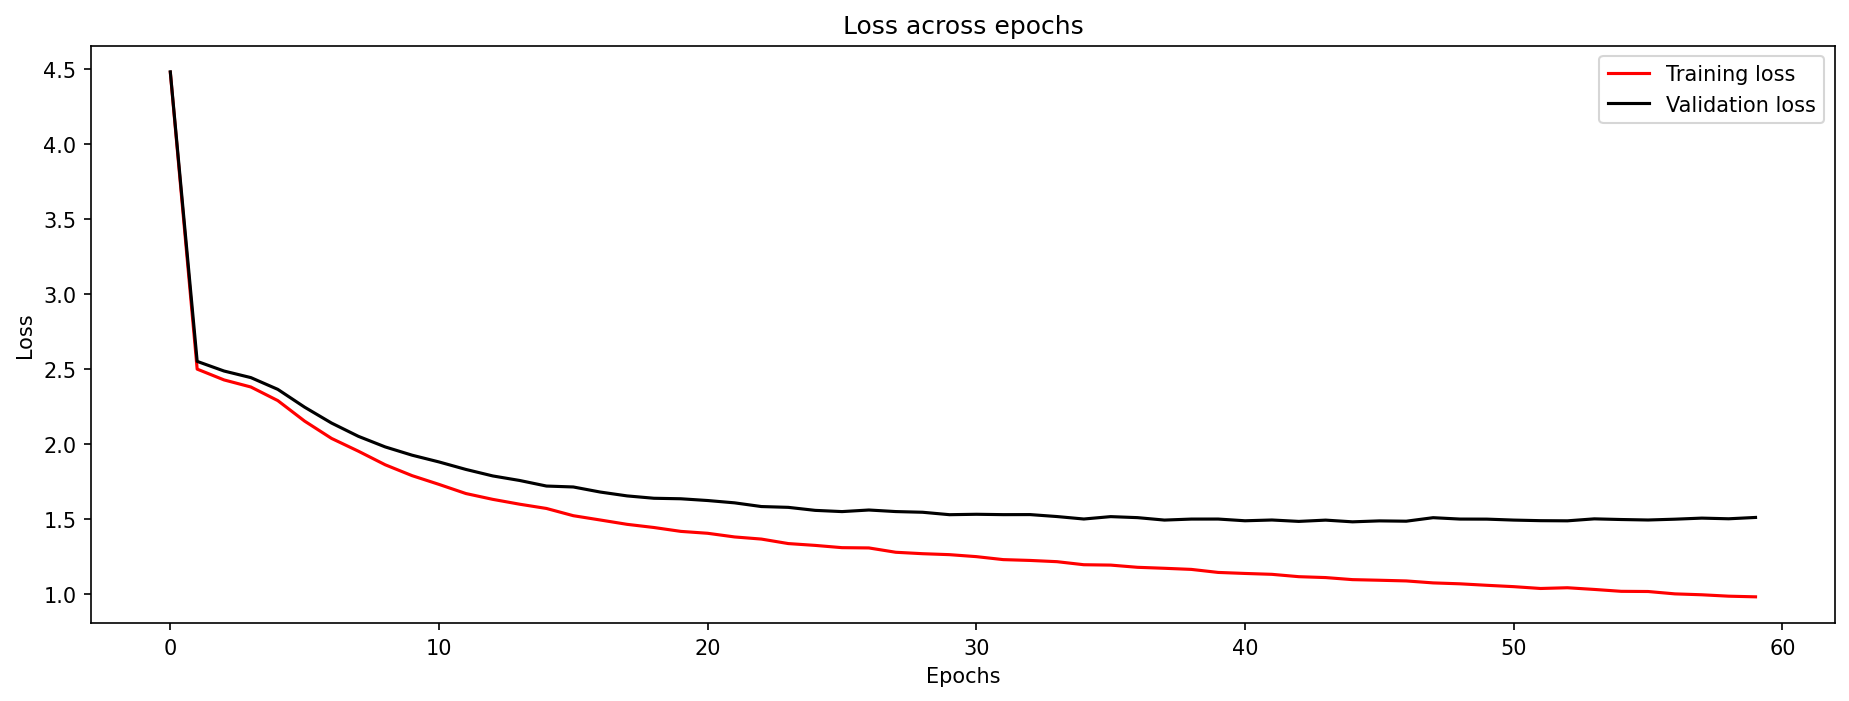

In [18]:
plt.figure(figsize=(15,5),dpi = 150)
sns.lineplot(x = range(len(training_loss_lst)),y = [val.item() for val in training_loss_lst],color = 'red',label = 'Training loss')
sns.lineplot(x = range(len(validation_loss_lst)),y = [val.item() for val in validation_loss_lst],color = 'black',label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss across epochs')
plt.show()